In [ ]:
import os
import gc
import PIL
import pytz
import time
import shutil
import random
%pip install split-folders
import splitfolders
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
from datetime import datetime,timezone
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
input_dir = '/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake'
output_dir =  "/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/dataset"
#splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.7,.15,.15), group_prefix=None)


In [ ]:
DATADIR = output_dir
TRAIN_DATADIR = os.path.join(DATADIR, 'train')
TEST_DATADIR = os.path.join(DATADIR, 'test')
VAL_DATADIR = os.path.join(DATADIR, 'val')

In [ ]:
CATEGORIES = []
for c in os.listdir(TRAIN_DATADIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['Flood', 'Earthquake', 'Cyclone', 'Wildfire']


In [ ]:
plt.figure(figsize=(20,20))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATADIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(len(CATEGORIES),5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break
plt.tight_layout()        
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SHAPE = (224,224,3)


In [ ]:
def min_max_scalar(img, scale_range =(0, 1)):
    
    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img

def resize(img,size):
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array

def del_corrupted_images(filepaths):
    del_count = 0
    for filepath in filepaths:
        try:
            fobj = open(filepath,'rb')
            is_JFIF =  b'JFIF' in fobj.peek(10)
        finally:
            fobj.close()
        if not is_JFIF:
            del_count += 1
            os.remove(filepath)
    print(f"Total {del_count} corrupted image deleted")
    return None

def find_filepaths(root_folder):
    filepaths = []
    for dirname, _, filenames in os.walk(root_folder):
        for filename in filenames:
            filepaths.append(os.path.join(dirname, filename))
    return filepaths

In [ ]:
def load_and_prepare_dataset(dataset_dir,IMG_SHAPE):
    
    rock_classes = os.listdir(dataset_dir)
    
    filepaths = find_filepaths(dataset_dir)
    no_of_total_images = len(filepaths)
    
    data = np.zeros((no_of_total_images,*IMG_SHAPE),dtype='float32')
    label = []
    ix = 0
    
    for class_label in rock_classes:
        class_path = os.path.join(dataset_dir, class_label)
        for img in os.listdir(class_path):
            image = Image.open(os.path.join(class_path, img))
            resized_image = resize(image,IMG_SHAPE[:-1])
            image_array = min_max_scalar(resized_image)
            if image_array.shape == IMG_SHAPE:
                data[ix]=image_array
                label.append(class_label)
            else:
                image_array=np.stack((image_array,)*3, axis=-1)
                data[ix]=image_array
                label.append(class_label)
            ix += 1
    label = np.asarray(label)
    label = label.reshape((-1,1))
        
    return data,label

In [ ]:
X_train,y_train = load_and_prepare_dataset(TRAIN_DATADIR,IMG_SHAPE)
X_val,y_val = load_and_prepare_dataset(VAL_DATADIR,IMG_SHAPE)
X_test,y_test = load_and_prepare_dataset(TEST_DATADIR,IMG_SHAPE)

In [ ]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (3097, 224, 224, 3)
Shape of y_train = (3097, 1)
Shape of X_val = (662, 224, 224, 3)
Shape of y_val = (662, 1)
Shape of X_test = (668, 224, 224, 3)
Shape of y_test = (668, 1)


In [ ]:
def show_unique_images(X,y,idx=0):
    y = np.squeeze(y)
    unique = np.unique(y)
    index=[]
    for i in unique:
        try:
            r = np.where(y==i)
            index.append (r[0][idx])
        except:
            pass
    
    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])
    
    plt.figure(figsize=(16,9))
    
    for i in range(np.unique(y).size):
        ax = plt.subplot(1,8, i+1)
        
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
        
    return None

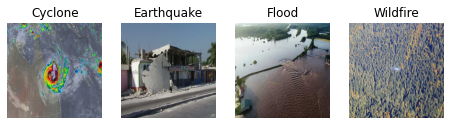

In [ ]:
show_unique_images(X_train,y_train)

In [ ]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values = Counter(np.squeeze(y_train).tolist()).values()
rock_count_per_class_before_smote = dict(zip(classes,values))
print(rock_count_per_class_before_smote)

{'Flood': 751, 'Earthquake': 944, 'Cyclone': 649, 'Wildfire': 753}


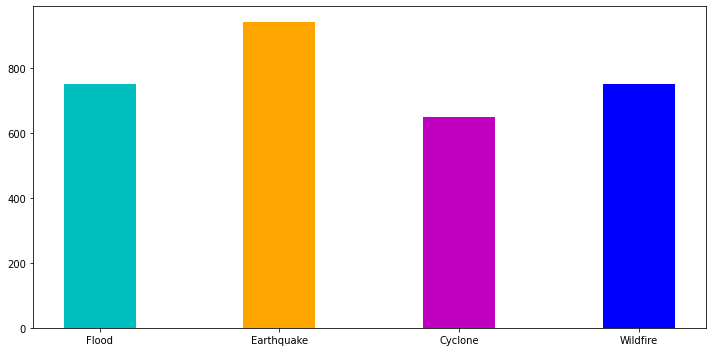

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
rock_names = list(rock_count_per_class_before_smote.keys())
rock_counts = list(rock_count_per_class_before_smote.values())
plt.bar(rock_names,rock_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()  

In [ ]:
def one_hot_encoder(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array

In [ ]:
y_train_encoded = one_hot_encoder(y_train)
y_val_encoded = one_hot_encoder(y_val)
y_test_encoded = one_hot_encoder(y_test)

In [ ]:
class PrettyPrint(tf.keras.callbacks.Callback):
    
    def __init__(self,batches):
        super(PrettyPrint,self).__init__()
        self.batches = batches
        self.lr = None

    
    def print_in_color(self,txt_msg,fore_tupple,back_tupple,):
        #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
        #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
        rf,gf,bf=fore_tupple
        rb,gb,bb=back_tupple
        msg='{0}' + txt_msg
        mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
        print(msg .format(mat), flush=True)
        print('\33[0m', flush=True) # returns default print color to back to black
        return None

    def on_train_begin(self, logs=None):
        msg=f"{'Epoch':^10s}{'Train_Loss':^12s}{'Train_Acc':^12s}{'Val_Loss':^12s}{'Val_Acc':^12s}{'LR':^12s}{'Duration':^10s}"
        self.print_in_color(msg, (0, 255, 76), (55,65,80))
        self.lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

        
    def on_train_end(self, logs=None):
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        self.print_in_color(msg,  (255,100,255), (55,65,80))
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count
        
    def on_epoch_begin(self,epoch, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        end_time =time.time()
        duration = end_time-self.start_time
        
        lr = self.lr
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        if self.lr != current_lr:
            self.lr = current_lr 
            
        train_acc = logs.get('accuracy')*100
        train_loss = logs.get('loss')
        val_acc = logs.get('val_accuracy')*100
        val_loss =logs.get('val_loss')
        
        msg = f"{str(epoch+1):^10s}{train_loss:^12.3f}{train_acc:^12.3f}{val_loss:^12.5f}{val_acc:^12.5f}{lr:^12.9f}{duration:^10.3f}"
        self.print_in_color (msg,(0,255,255), (55,65,80))

In [ ]:
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(3097, 224, 224, 3)
(3097, 4)
(662, 224, 224, 3)
(662, 4)


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1_l2

In [ ]:
BaseModel = ResNet50(weights='imagenet', include_top=False, input_shape= IMG_SHAPE )

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
output_size = len(y_train_encoded[0])
print(f"Output Size = {output_size}")

Output Size = 4


In [ ]:
model = Sequential()

model.add(BaseModel)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu',
                kernel_regularizer=l1_l2(0.01),
                bias_regularizer=l1_l2(0.01)))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(output_size, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adamax(learning_rate=0.0001),
              metrics=['accuracy']) 

In [ ]:
batch_size = 64
train_steps=int(len(y_train)/batch_size)
batches=train_steps

color_print = PrettyPrint(batches)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                                 patience=1,verbose=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,verbose=0,
                                              restore_best_weights=True)

callbacks = [color_print,reduce_lr,early_stop]

In [ ]:
history = model.fit(X_train,y_train_encoded, 
                    validation_data=(X_val,y_val_encoded),
                    batch_size=batch_size, epochs=30,verbose=0,
                    callbacks=callbacks)

  Epoch    Train_Loss  Train_Acc    Val_Loss    Val_Acc        LR      Duration 

    1       712.095      85.599    487.04669    24.32024  0.000100000   56.229  

    2       345.538      94.123    226.68958    24.32024  0.000100000   32.392  

    3       152.482      96.028     96.02353    24.32024  0.000100000   33.968  

    4        62.649      97.869     40.21444    24.32024  0.000100000   34.454  

    5        26.627      98.934     18.89188    24.32024  0.000100000   33.649  

    6        12.448      99.322     11.69996    24.32024  0.000100000   34.215  

    7        7.684       99.257     9.25567     23.86707  0.000100000   34.518  

    8        6.662       98.127     9.24343     26.28399  0.000100000   34.119  

    9        5.572       98.934     5.30100     31.57100  0.000100000   34.078  

    10       4.526       98.418     6.17523     30.51360  0.000100000   34.237  

    11       3.162       99.580     3.45883     41.08761  0.000100000   34.265  

    12       2.5

In [ ]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))
    
    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()
    
    return None

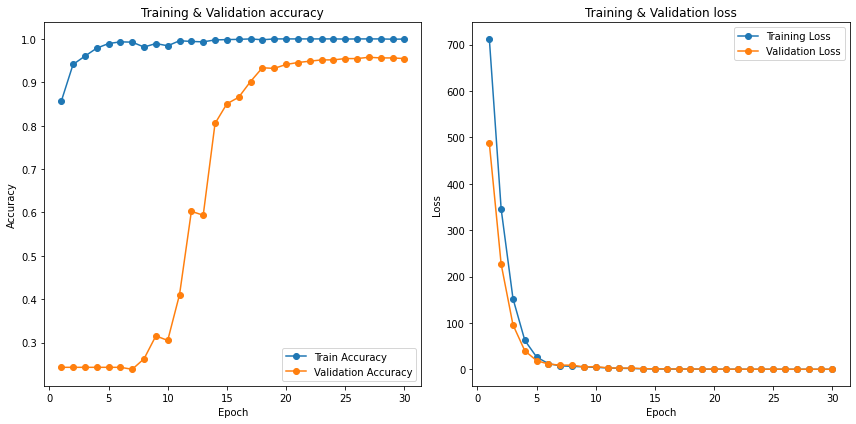

In [ ]:
plot_accuracy_loss(history)

In [ ]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

21/21 [==============================] - 2s 109ms/step - loss: 0.4473 - accuracy: 0.9611
[0.4472511112689972, 0.961077868938446]


In [ ]:
def label_encoder(string):
    _classes = ['Flood', 'Earthquake', 'Cyclone', 'Wildfire']
    for i,cls in enumerate(_classes):
        if string == cls:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

[2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.96      0.96      0.96       204
           2       0.00      0.00      0.00       140
           3       0.96      0.98      0.97       162

    accuracy                           0.53       668
   macro avg       0.48      0.48      0.48       668
weighted avg       0.53      0.53      0.53       668



In [ ]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

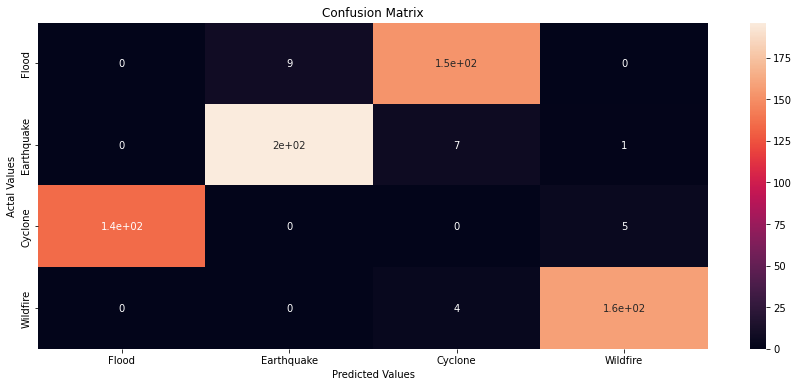

In [ ]:
labels =  ['Flood', 'Earthquake', 'Cyclone', 'Wildfire']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

In [ ]:
model.save('/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/resnet50.h5')


In [ ]:
print(X_test[0][0][0])

[0.05490196 0.11764706 0.07450981]


In [ ]:
prediction = model.predict(X_test)
print(CATEGORIES[int(prediction[0][0])])

Flood


In [ ]:
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
import argparse
import cv2

In [ ]:
lables = ['Flood', 'Earthquake', 'Cyclone', 'Wildfire']
# initialize the predictions queue
Q = deque(maxlen=128)

# initialize the video stream, pointer to output video file, and
# frame dimensions
print("processing video...")
vs = cv2.VideoCapture('/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/floods_101_nat_geo.mp4')
#vs= VideoStream(src=0).start()
writer = None
(W, H) = (None, None)
 
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
 
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break
 
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# clone the output frame, then convert it from BGR to RGB
	# ordering and resize the frame to a fixed 224x224
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, (224, 224))
	frame = frame.astype("float32")
	
	# make predictions on the frame and then update the predictions
	# queue
	preds = model.predict(np.expand_dims(frame, axis=0))[0]
	Q.append(preds)

	# perform prediction averaging over the current history of
	# previous predictions
	results = np.array(Q).mean(axis=0)
  
	i = np.argmax(results)
	label = labels[i]

	# draw the activity on the output frame
	text = "Detected: {}".format(label)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)
 
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter('/content/drive/MyDrive/Cyclone_Wildfire_Flood_Earthquake/f-output.avi', fourcc, 30,
			(W, H), True)
 
	# write the output frame to disk
	writer.write(output)
 

 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

processing video...
[INFO] cleaning up...
